In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/D-Fire.zip'  # Update with your dataset path


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/D-Fire.zip"  # Update with your actual ZIP file path
extract_path = "/content/d-fire-dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import os


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class FireSmokeDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))  # Get all image file names

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.txt'))

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load labels (Bounding Boxes)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = f.readlines()
        else:
            labels = []  # No objects in the image

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, labels


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG16 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # VGG16 normalization
])


In [ ]:
train_data = FireSmokeDataset(
    image_dir='/content/d-fire-dataset/train/images',
    label_dir='/content/d-fire-dataset/train/labels',
    transform=transform
)

test_data = FireSmokeDataset(
    image_dir='/content/d-fire-dataset/test/images',
    label_dir='/content/d-fire-dataset/test/labels',
    transform=transform
)


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust as needed

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")


Train samples: 17221, Test samples: 4306


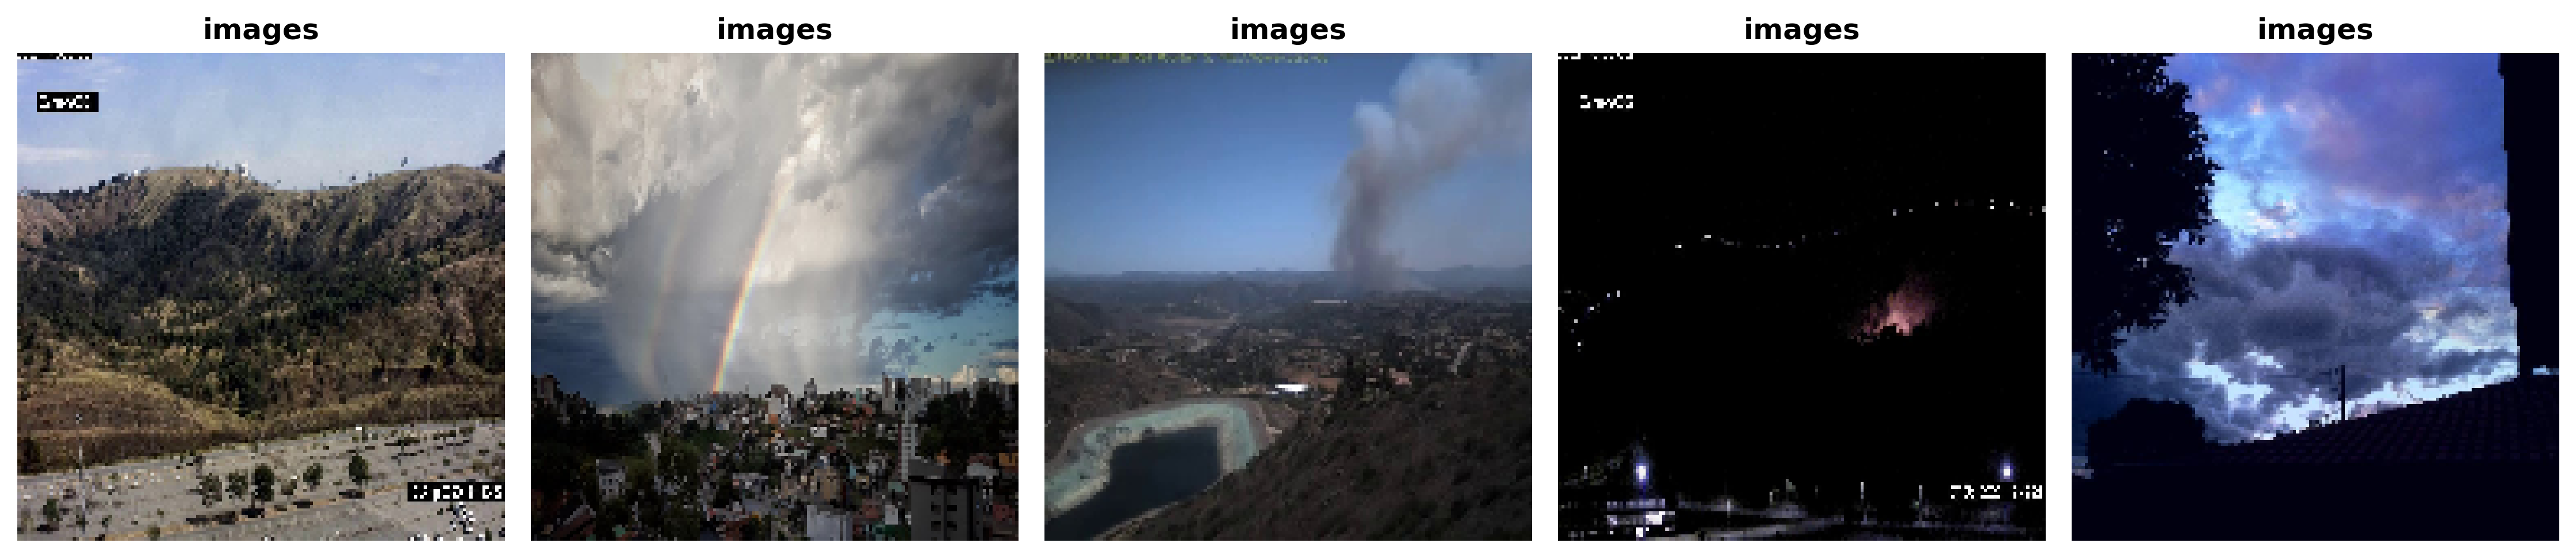

<ipython-input-12-46d901dc2dad>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Class"], y=df["Count"], palette="coolwarm")


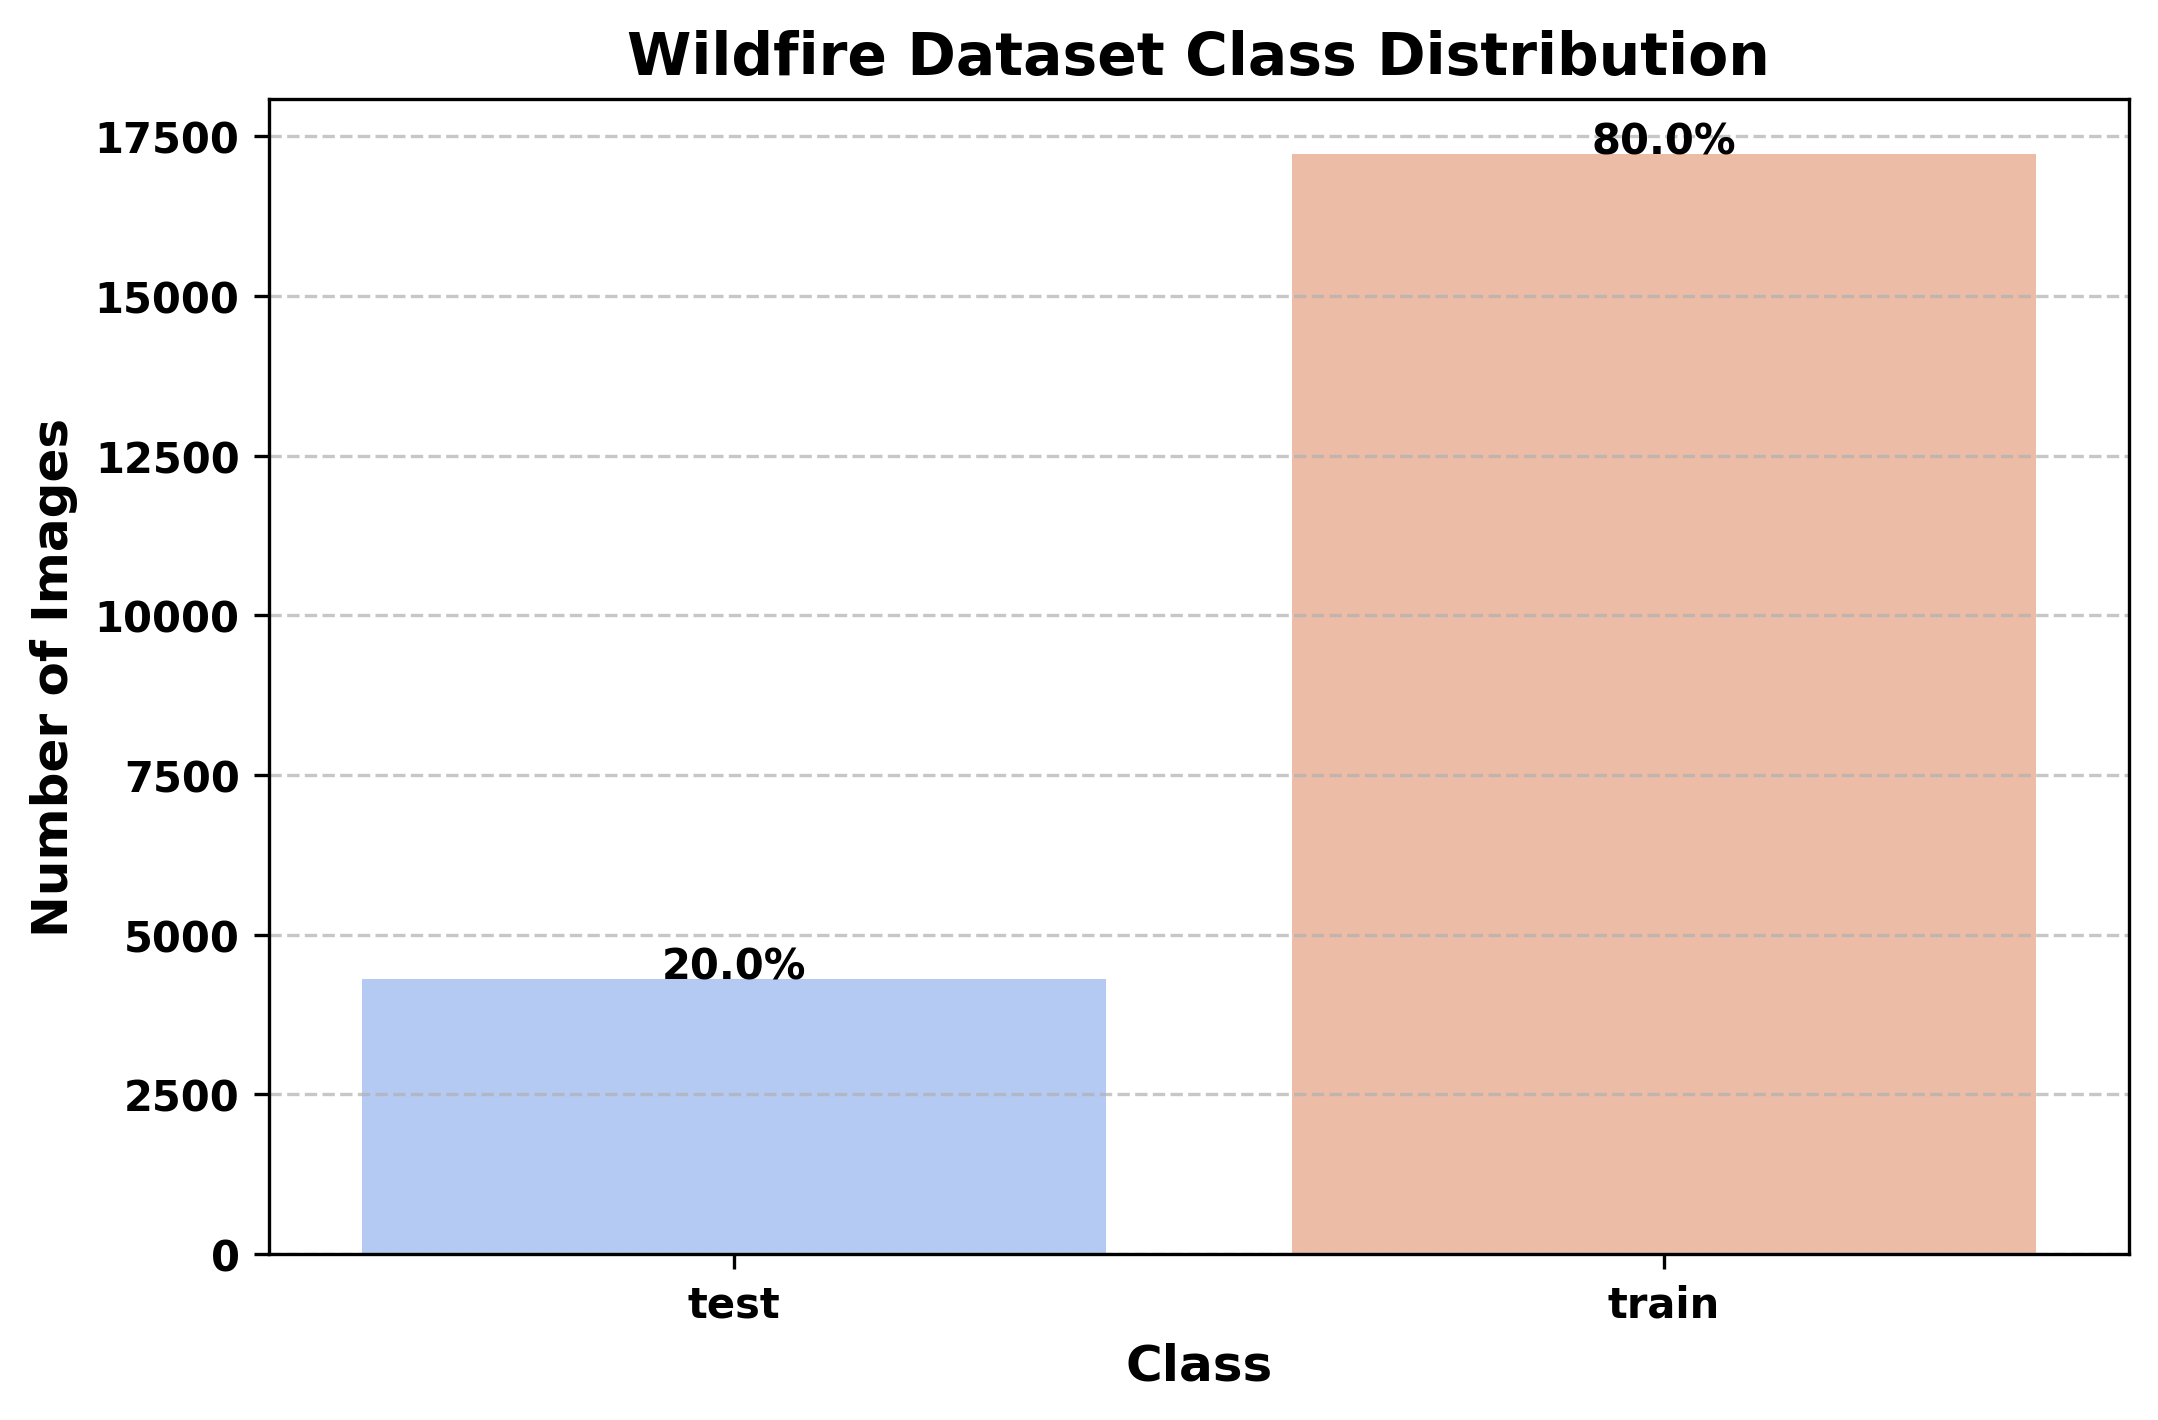

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import cv2

# Define dataset path
dataset_path = "/content/d-fire-dataset"  # Update if needed

# Function to get all image file paths
def get_image_files(dataset_path):
    image_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

# Function to display sample images
def show_sample_images(dataset_path, num_images=5):
    image_files = get_image_files(dataset_path)
    if len(image_files) < num_images:
        print("Not enough images to display!")
        return

    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5), dpi=300)

    for i, img_path in enumerate(selected_images):
        img = image.load_img(img_path, target_size=(150, 150))
        axes[i].imshow(img)
        axes[i].set_title(os.path.basename(os.path.dirname(img_path)), fontsize=12, fontweight='bold')
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Show random sample images
show_sample_images(dataset_path)

# Visualizing Class Distribution
# Count images in each class
class_counts = {}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        class_counts[category] = len(get_image_files(category_path))

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df["Percentage"] = (df["Count"] / df["Count"].sum()) * 100

# Plot the distribution
plt.figure(figsize=(8, 5), dpi=300)
sns.barplot(x=df["Class"], y=df["Count"], palette="coolwarm")
plt.xlabel("Class", fontsize=12, fontweight='bold')
plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
plt.title("Wildfire Dataset Class Distribution", fontsize=14, fontweight='bold')

# Show percentages on bars
for index, row in df.iterrows():
    plt.text(index, row["Count"] + 5, f'{row["Percentage"]:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5), dpi=300)
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Function to apply Grad-CAM
def apply_gradcam(model, img_path, layer_name):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    heatmap = cv2.resize(heatmap.numpy(), (150, 150))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 5), dpi=300)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM Visualization')
    plt.show()

# Example usage (Replace with real values when available)
# plot_confusion_matrix(y_true, y_pred, class_names=['No Fire', 'Fire'])
# plot_roc_curve(y_true, y_scores)
# apply_gradcam(trained_model, 'sample_fire_image.jpg', 'block5_conv3')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models


model = models.vgg16(pretrained=True)


model.classifier[6] = nn.Linear(4096, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class FireSmokeDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.txt'))


        image = Image.open(img_path).convert("RGB")


        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = list(map(float, line.strip().split()))
                    boxes.append(parts)  # Format: [class, x_center, y_center, width, height]


        boxes = torch.tensor(boxes) if boxes else torch.zeros((0, 5))  # If no labels, return empty tensor

        if self.transform:
            image = self.transform(image)

        return image, boxes


In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    images = torch.stack(images, dim=0)
    return images, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_data = FireSmokeDataset(
    image_dir='/content/d-fire-dataset/train/images',
    label_dir='/content/d-fire-dataset/train/labels',
    transform=transform
)

test_data = FireSmokeDataset(
    image_dir='/content/d-fire-dataset/test/images',
    label_dir='/content/d-fire-dataset/test/labels',
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")


Train samples: 17221, Test samples: 4306


In [ ]:
loss_values = []
accuracy_values = []


In [ ]:
num_epochs = 10
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)


        labels = torch.tensor([1 if len(label) > 0 else 0 for label in labels]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


    loss_values.append(running_loss / len(train_loader))
    accuracy_values.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10, Loss: 0.3204, Accuracy: 85.01%
Epoch 2/10, Loss: 0.1491, Accuracy: 94.18%
Epoch 3/10, Loss: 0.0953, Accuracy: 96.41%
Epoch 4/10, Loss: 0.0747, Accuracy: 97.38%



Plot Training Loss and Accuracy Curves


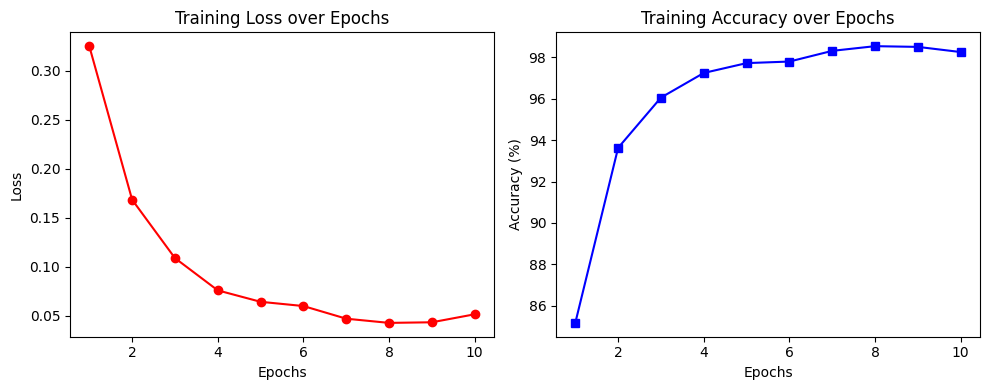

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_values, marker='s', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')

plt.tight_layout()
plt.show()


Plot ROC & AUC

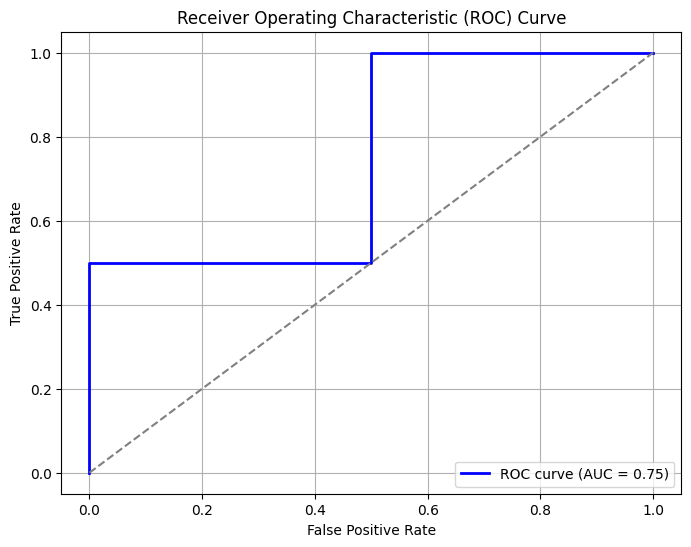

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Confusion Matrix

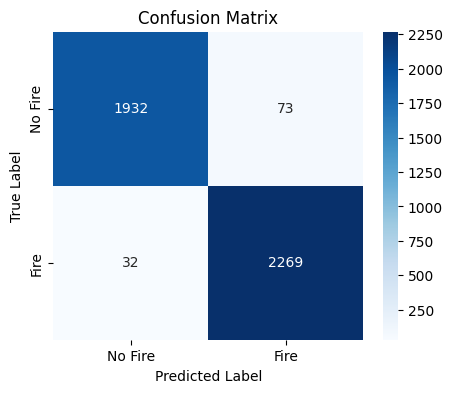

              precision    recall  f1-score   support

     No Fire       0.98      0.96      0.97      2005
        Fire       0.97      0.99      0.98      2301

    accuracy                           0.98      4306
   macro avg       0.98      0.97      0.98      4306
weighted avg       0.98      0.98      0.98      4306



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor([0 if len(label) == 0 else 1 for label in labels]).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['No Fire', 'Fire']))


Model Performance in a Table

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = np.sum(y_true == y_pred) / len(y_true)  # Fix: Use np.sum()

df_results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1]
})

print(df_results)


      Metric     Value
0   Accuracy  0.975615
1  Precision  0.968830
2     Recall  0.986093
3   F1-Score  0.977385


Time Complexity

Memory Usage

In [ ]:
import psutil

memory_used = psutil.Process().memory_info().rss / 1024**2
print(f"Memory Used: {memory_used:.2f} MB")


Memory Used: 1796.31 MB
